In [1]:
#!pip install --upgrade python-graphblas[default]
#!pip install --upgrade pandas
#!pip install --upgrade matplotlib
#!pip install --upgrade scipy
#!pip install --upgrade networkx
#!pip install --upgrade fast-matrix-market
#!pip install --upgrade igraph
#!pip install --upgrade pycairo

In [2]:
import julia; julia.install(quiet=True)
from julia import Main

import networkx as nx
import numpy as np

import holoviews as hv; hv.extension('bokeh', 'plotly', 'matplotlib', logo=False)
import panel as pn;     pn.extension('plotly', 'katex', 'mathjax')
from panel.interact import interact
import hvplot.networkx as hvnx

from alg_graphs.alg_graphs import pr, nxgraph_from_adjacencymatrix, draw_nxgraph, draw_nxmultigraph, nx_from_pygsp, NxDisplay, raster

%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [3]:
import matplotlib; import bokeh
print({ i.__name__ : i.__version__ for i in [pn, hv, matplotlib, bokeh, np]})
#{'panel': '1.3.6', 'holoviews': '1.18.0', 'matplotlib': '3.8.2', 'bokeh': '3.3.2', 'numpy': '1.26.2'}

{'panel': '1.3.6', 'holoviews': '1.18.1', 'matplotlib': '3.8.2', 'bokeh': '3.3.2', 'numpy': '1.26.2'}


In [4]:
%%julia
using Graphs, LinearAlgebra, Laplacians

Entropy pool not available to seed RNG; using ad-hoc entropy sources.

<div style="float:center;width:100%;text-align: center;"><strong style="height:60px;color:darkred;font-size:40px;">Drawing Graphs With Python</strong></div>

There are many packages that can be used to draw Graph Structures. With Python, we will mostly use 
*  [**the holoviews Graph element**](https://holoviews.org/user_guide/Network_Graphs.html), since it provides ready interactivity
*  [**the holoviews hvplot.networkx interface**](https://networkx.org/).
* See [**networkx drawing documentation**](https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) for other options
* See [**the GraphBLAS primer**](https://python-graphblas.readthedocs.io/en/stable/getting_started/primer.html) for information about GraphBLAS

# 1. Holoviews Graph

The Holoviews Graph Element holds the abstract edges stored as a **table of node indices.**
* Nodes hold a node index together with x and y positions.<br>
The Nodes may also define any number of value dimensions, revealed when hovering over the nodes or used to color the nodes by.
* EdgePaths can optionally be supplied to declare explicit node paths.

In [5]:
N = 8
source       = np.random.randint(0,N, N)
target       = np.arange(N, dtype=np.int32)

pr( "Holoviews Graph Element, loops are displayed as in-arrows")
pn.Row( hv.Graph( ((source, target),) )\
          .opts(title="Directed Graph", width=200, height=200, xaxis=None, yaxis=None,
                directed=True, node_size=5, arrowhead_length=0.05),
        hv.Graph( ((source, target),) )\
          .opts(title="Undirected Graph", width=200, height=200, xaxis=None, yaxis=None,
                node_size=8)
      )

<strong style="font-size:20px;height:25px;color:blue;">Holoviews Graph Element, loops are displayed as in-arrows</strong>

Row
    [0] HoloViews(Graph, height=200, sizing_mode='fixed', width=200)
    [1] HoloViews(Graph, height=200, sizing_mode='fixed', width=200)

# 2. Networkx Graph

## 2.1. Use Networkx Drawing Routines

<strong style="font-size:20px;height:25px;color:blue;">Graph produced with networkx plot and displayed with panel</strong>

Row
    [0] Matplotlib(Figure, dpi=96, width=400)
    [1] Matplotlib(Figure, dpi=114, width=400)
    [2] Matplotlib(Figure, dpi=114, width=400)
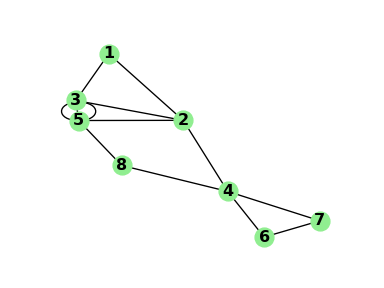
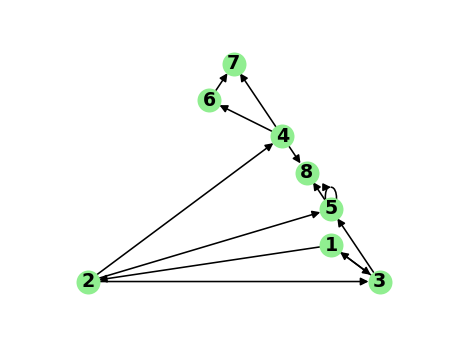
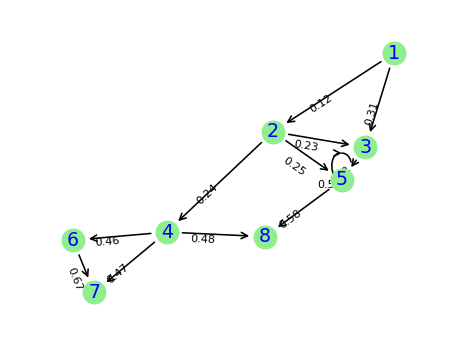

In [6]:
def mk_graph(G):
    G.add_nodes_from(range(1,9))
    #G.add_edges_from([(1,2), (1,3), (2,3), (2,4), (2,5), (3,1), (3,5), (4,6), (4,7), (4,8), (5,8), (6,7),(5,5)])
    G.add_weighted_edges_from([(1,2, .12), (1,3, .13), (2,3, .23), (2,4,.24), (2,5,.25), (3,1,.31), (3,5,.35), (4,6,.46), (4,7,.47), (4,8,.48), (5,8,.58), (6,7,.67),(5,5,.55)])
    G.nodes[1]["stuff"] = 3 
    G.edges[3, 5]['weight'] = 4.2

G = nx.Graph();   mk_graph(G)
D = nx.DiGraph(); mk_graph(D)

figG = draw_nxgraph( G, layout=nx.spring_layout )
figD = draw_nxgraph( D, layout=nx.planar_layout )
figE = draw_nxmultigraph(G, layout=nx.spring_layout, e_lbl='weight', elabel_options={ 'font_color': 'black', 'font_size': 7, 'horizontalalignment': 'right', 'verticalalignment': 'top'}) # 'rotate': False} )

pr("Graph produced with networkx plot and displayed with panel")
pn.Row( pn.pane.Matplotlib( figG, dpi=96,  width=400),
        pn.pane.Matplotlib( figD, dpi=114, width=400),
        pn.pane.Matplotlib( figE, dpi=114, width=400),
      )

## 2.2 Use Holoviews Drawing Routines

### 2.2.1 Use the Holoviews Graph Element Directly

In [7]:
pr("Networkx Graph converted to hv.Graph Element and displayed with panel")
pn.Row(hv.Graph.from_networkx(G, nx.layout.spectral_layout).opts(tools=['hover'])\
         .opts( title="Directed Graph", width=200, height=200, xaxis=None, yaxis=None,
                directed=True, node_size=5, arrowhead_length=0.05),
       hv.Graph.from_networkx(D, nx.layout.fruchterman_reingold_layout, k=1)\
         .opts(title="Undirected Graph", width=200, height=200, xaxis=None, yaxis=None,
                node_size=8))

<strong style="font-size:20px;height:25px;color:blue;">Networkx Graph converted to hv.Graph Element and displayed with panel</strong>

Row
    [0] HoloViews(Graph, height=200, sizing_mode='fixed', width=200)
    [1] HoloViews(Graph, height=200, sizing_mode='fixed', width=200)

In [8]:
#hv.help(hvnx.draw)
G = nx.Graph()

G.add_edge('a', 'b', weight=0.6)
G.add_edge('a', 'c', weight=0.2)
G.add_edge('c', 'd', weight=0.1)
G.add_edge('c', 'e', weight=0.7)
G.add_edge('c', 'f', weight=0.9)
G.add_edge('a', 'd', weight=0.3)

G.add_node('a', size=20)
G.add_node('b', size=10)
G.add_node('c', size=12)
G.add_node('d', size=5)
G.add_node('e', size=8)
G.add_node('f', size=3)

pos = nx.spring_layout(G)  # positions for all nodes
h   = hvnx.draw(G, pos,
                node_color="lightgreen", with_labels=True, font_weight='bold', font_color='black', #font_size=14,
                node_size=hv.dim('size')*70,
                edge_color='weight', edge_cmap='kg', edge_width=hv.dim('weight')*10,
                arrows=True, arrowhead_length=0.04,
          colorbar=True ).opts(width=600, tools=['hover', 'box_select'])
pn.Row(h)

Row
    [0] HoloViews(Overlay, height=400, sizing_mode='fixed', width=600)

### 2.2.2 Use the NxDisplay Viewer from display_routines.py

In [9]:
def mk_graph(N,p):
    def rand_adj(n,p):
        A        = np.zeros((n,n))
        for i in range(n):
            for j in range(i):
                if np.random.uniform() < p:
                    A[i,j] = 1.+np.random.rand()
                    A[j,i] = A[i,j]
        return A
    import pygsp
    g = pygsp.graphs.Graph(rand_adj(N,p))
    #g.set_coordinates('spring')
    return g

In [10]:
N = 12
pygspG = mk_graph(N, (np.log(N)+1)/N)
G = nx_from_pygsp( pygspG )
f = 10.*np.random.uniform(-1, 1, size=N)
if False:
    display.set_G(g); display.set_node_signal(f, update_plot=True)
else:
    display = NxDisplay(G, f, s=None)
    h = pn.Row( pn.Param(display, width=180,width_policy="min"), display.plot_layout())
h

Row
    [0] Param(NxDisplay, width=180, width_policy='min')
    [1] Column(width=800)
        [0] HoloViews(Overlay, height=800, sizing_mode='fixed', width=800)
        [1] Row
            [0] HoloViews(HeatMap, sizing_mode='fixed', width=260)
            [1] HoloViews(HeatMap, sizing_mode='fixed', width=260)

In [11]:
# We can modify the display programmatically
display.edge_width=1

## 2.3. Matplotlib Based Graph with ColorBar

<class 'networkx.classes.digraph.DiGraph'> DiGraph with 4 nodes and 16 edges


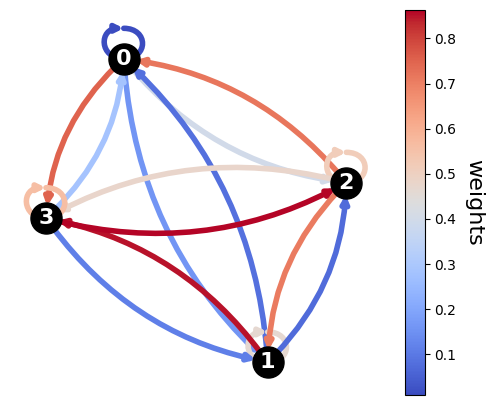

In [12]:
#from collections.abc import Iterable

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

%matplotlib inline


def make_graph(nodes, M: np.ndarray, G: nx.classes.digraph.DiGraph=nx.DiGraph()):
    """Build graph based on list of nodes and a weight matrix
    Args:
        nodes (list): Graph nodes
        M (np.ndarray): Weight matrix
        G (nx.classes.digraph.DiGraph, optional): Graph type. Defaults to nx.DiGraph().
    Returns:
        [type]: Graph object
    Example:
        >>> n_nodes = 4
        >>> M = np.random.rand(n_nodes, n_nodes)
        >>> nodes = range(M.shape[0])
        >>> G = make_graph(nodes, M)
    """

    for node in nodes:
        G.add_node(node, label=f"{node}")
        
    for i, origin_node in enumerate(nodes):
        for j, destination_node in enumerate(nodes):
            if M[i, j] != 0:
                G.add_edge(origin_node, destination_node, weight=M[i, j]
                            ,label=f"{M[i, j]:0.02f}")

    return G


def graphplot(G: nx.classes.digraph.DiGraph, M: np.ndarray
            ,min_weight_threshold: float=0.0, bins: int=4
            ,graph_layout: str="spring_layout"
            ,figsize: tuple=(20, 10)
            ,cmap=plt.cm.coolwarm
            ,edge_kwargs=None, node_label_kwargs=None, node_kwargs=None
            ):
    """Plot a graph with weights on edges
    Args:
        G (nx.classes.digraph.DiGraph): Weighted graph
        M (np.ndarray): Weight matrix
        min_weight_threshold (float, optional): Minimal weight to be plotted. Defaults to 0.0.
        bins (int, optional): Number of bins to divide the weights. Defaults to 4.
        graph_layout (str, optional): Defaults to "spring_layout".
        figsize (tuple, optional): Defaults to (20, 10).
        cmap ([type], optional): Matplotlib colormap. Defaults to plt.cm.coolwarm.
        edge_kwargs ([type], optional): Kwargs to edge plot. Defaults to None.
    Returns:
        ax: Plotted graph
    Example:
        >>> n_nodes = 4
        >>> M = np.random.rand(n_nodes, n_nodes)
        >>> nodes = range(M.shape[0])
        >>> G = make_graph(nodes, M)
        >>> graphplot(G, M)
    References:
        [1] https://networkx.org/documentation/stable/auto_examples/drawing/plot_directed.html
    """
    node_kwargs = node_kwargs or {"node_color": "k", "node_size": 500}

    edge_kwargs = edge_kwargs or {"edge_color" :nx.get_edge_attributes(G, 'weight').values()
                    ,"edge_cmap": cmap
                    ,"width": 4
                    ,"connectionstyle":'arc3, rad=0.2'
                    }

    node_label_kwargs = node_label_kwargs or {"font_color": "w", "font_size": 16
                                    ,"font_weight": "bold"
                                    }

    pos = getattr(nx, graph_layout)(G)

    fig, ax = plt.subplots(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, ax=ax, **node_kwargs)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label')
                            ,ax=ax, **node_label_kwargs)
    edges = nx.draw_networkx_edges(G, pos, ax=ax, **edge_kwargs)

    # Configure colorbar
    _, bin_edges = np.histogram(
                    np.ma.masked_array(M, mask=M==min_weight_threshold).compressed()
                    ,bins=bins)

    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    cmap_array = list(bin_edges)
    pc.set_array(cmap_array)
    cbar = plt.colorbar(pc, ax=ax);
    cbar.set_label('weights', rotation=270, fontsize=16, labelpad=20)

    # ax = plt.gca()
    ax.set_axis_off()
    return fig
M = np.random.rand(4,4)
G = make_graph( range(M.shape[0]), M )
print(type(G), G)
pn.Row( pn.pane.Matplotlib(graphplot(G,M, figsize=(6,5)), dpi=96));

# 3. Igraph

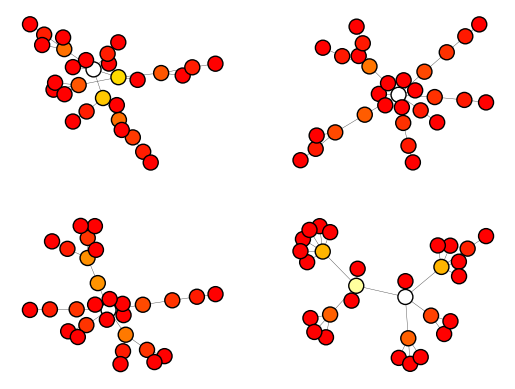

In [13]:
import igraph as ig
import random

visual_style = {
    "edge_width": 0.3,
    "vertex_size": 15,
    "palette": "heat",
    "layout": "fruchterman_reingold"
}
gs = [ig.Graph.Barabasi(n=30, m=1) for i in range(4)]
betweenness = [g.betweenness() for g in gs]
colors = [[int(i * 255 / max(btw)) for i in btw] for btw in betweenness]

fig, axs = plt.subplots(2, 2)
for g, color, ax in zip(gs, colors, axs.ravel()):
    ig.plot(g, target=ax, vertex_color=color, **visual_style)

pn.pane.Matplotlib(fig);

# 4. Access Julia Data Structures, Draw with Python

In [14]:
%%julia
G = Graph(4) # graph with 3 vertices

# make a triangle
add_edge!(G, 1, 2)
add_edge!(G, 1, 3)
add_edge!(G, 2, 3)
add_edge!(G, 2, 4)

aG = adjacency_matrix(G);

<strong style="font-size:20px;height:25px;color:blue;">Construct networkx graph from Julia adjacency matrix and display in panel</strong>

Row
    [0] HoloViews(Raster, height=200, sizing_mode='fixed', width=200)
    [1] Matplotlib(Figure, dpi=114, height=200)
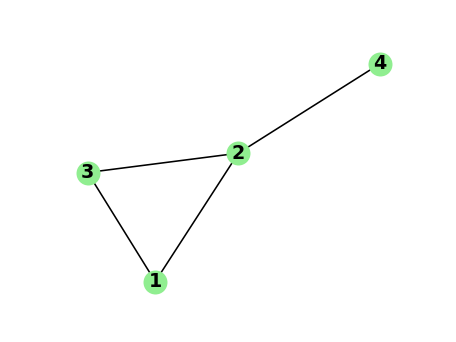

In [15]:
pr("Construct networkx graph from Julia adjacency matrix and display in panel")
pn.Row(raster(Main.aG).opts(width=200,height=200, title="Adjacency Matrix"),
       pn.pane.Matplotlib( draw_nxgraph( nxgraph_from_adjacencymatrix(Main.aG )), dpi=114, height=200)
)